# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ImageCaptioning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/13dGpwyY-c5FPJTEacGkw8XNTkbGVWT2D/ImageCaptioning


In [2]:
import re
import os
import cv2
import glob
import spacy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import clear_output


import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights


device = 'cuda' if torch.cuda.is_available() else 'cpu'
!python -m spacy download en_core_web_sm
clear_output()


# Dataset

In [3]:
spacy_eng = spacy.load("en_core_web_sm")

In [4]:
class Vocabulary:
    def __init__(self,freq_threshold):
        # Setting the pre-reserved tokens int to string tokens
        self.index2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}

        # String to int tokens
        # Tts reverse dict self.index2word
        self.word2index = {v: k for k, v in self.index2word.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.index2word)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.word2index[word] = idx
                    self.index2word[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [self.word2index[token] if token in self.word2index else self.word2index["<UNK>"] for token in tokenized_text ]

In [5]:
class ImageCaptioningDataset(Dataset):
    """Image Captioning dataset"""

    def __init__(self, csv_file, transform, max_length, freq_threshold=5):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform
        self.max_length = max_length

        self.images = self.dataframe['image']
        self.captions = self.dataframe['caption']

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_path = self.images[idx]

        image = cv2.imread(f'dataset/Images/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        # Tokenize caption
        caption_tokens = []
        caption_tokens += [self.vocab.word2index["<SOS>"]]
        caption_tokens += self.vocab.numericalize(caption)
        caption_tokens += [self.vocab.word2index["<EOS>"]]

        input_tokens = caption_tokens[:-1].copy() # input
        target_tokens = caption_tokens[1:].copy() # target

        # Padding input tokens
        cap_length = len(input_tokens)
        padding_size = self.max_length - cap_length
        input_tokens += [0] * padding_size
        target_tokens += [0] * padding_size

        input_tokens = torch.tensor(input_tokens) # input
        target_tokens = torch.tensor(target_tokens) # target

        return image, input_tokens, target_tokens

# Model

## Encoder

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, encoder_dim):
        super(Encoder, self).__init__()
        self.encoder_dim = encoder_dim

        # Load pretrained model and remove last fc layer
        pretrained_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(pretrained_model.children())[:-1])

        # Freeze layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Add a linear layer add the end of model
        self.linear = torch.nn.Linear(2048, self.encoder_dim)
        self.drop = torch.nn.Dropout(0.3)

    def forward(self, images):
        features = self.model(images)                     # (batch_size, 2048, 1, 1)
        features = features.view(images.shape[0], 1, -1)  # (batch_size, 1, 2048)
        features = self.linear(self.drop(features))       # (batch_size, 1, 512)
        features = features.squeeze(1)                    # (batch_size, 512)
        return features

## Decoder

In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, encoder_dim, decoder_dim, num_layers):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)

        # LSTM layer
        self.lstm = torch.nn.LSTM(input_size=embed_dim + encoder_dim,
                                  hidden_size=decoder_dim,
                                  bias=True,
                                  batch_first=True,
                                  num_layers=self.num_layers,
                                  bidirectional=False)

        # Linear layer
        self.linear1 = torch.nn.Linear(decoder_dim, decoder_dim)
        self.linear2 = torch.nn.Linear(decoder_dim, vocab_size)
        self.drop = torch.nn.Dropout(0.3)

    def init_hidden_state(self, features):
        hidden = torch.zeros(self.num_layers, features.size(0), self.decoder_dim).to(device)
        cell = torch.zeros(self.num_layers, features.size(0), self.decoder_dim).to(device)
        return hidden, cell

    def forward_step(self, features, embed_words):
        # Init hidden state
        hidden_state, cell_state = self.init_hidden_state(features)

        # Concat embedding and context vector
        features = features.unsqueeze(1)                             # (batch_size, feature_dim)
        features = features.repeat(1, embed_words.shape[1], 1)       # (batch_size, sequence_length, feature_dim)
        lstm_input = torch.cat((embed_words, features), dim=2)       # (batch_size, sequence_length, feature_dim + embed_dim)

        # Forward pass
        output, (hn, cn) = self.lstm(lstm_input, (hidden_state, cell_state))
        output = self.linear1(output)
        output = self.drop(output)
        output = self.linear2(output)
        return output

    def forward(self, features, sequences):
        # Embedding sequence
        embed_words = self.embedding(sequences)
        embed_words = embed_words.to(torch.float32)

        output = self.forward_step(features, embed_words)
        return output


    def predict(self, feature, vocab, max_length=20):
        # Embedding sequence
        word = torch.tensor(vocab.word2index['<SOS>']).view(1, -1)
        embed_words = self.embedding(word)

        captions = []
        for idx in range(max_length):
            # Predict word index
            output = self.forward_step(feature, embed_words)[:, -1]
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())

            if vocab.index2word[predicted_word_idx.item()] == "<EOS>":
                break

            # Procedd with the next predicted word
            next_embed_word = self.embedding(predicted_word_idx).unsqueeze(0)
            embed_words = torch.cat((embed_words, next_embed_word), dim=1)

        # Convert the vocab idx to words and return sentence
        return ' '.join([vocab.index2word[idx] for idx in captions])


    def predict_beam(self, feature, vocab, beam_k, max_length=20):
        captions = [
            [[vocab.word2index['<SOS>']], 0.0],
        ]
        hidden_state, cell_state = self.init_hidden_state(feature)

        while len(captions[0][0]) < max_length:
            temp = []
            for cap in captions:
                embed_word = self.embedding(torch.tensor([cap[0]]))
                output = self.forward_step(feature, embed_word)[:, -1]
                output = torch.nn.functional.softmax(output, dim=1)
                preds = torch.argsort(output, dim=1, descending=True)[0, :beam_k]
                for p in preds:
                    next_cap, score = cap[0][:], cap[1]
                    next_cap.append(p.item())
                    score += np.log(output[0][p].item())

                    temp.append([next_cap, score ])
            captions = temp
            captions = sorted(captions, reverse=True, key=lambda x: x[1])[:beam_k]

        # Convert the vocab idx to words and return sentence
        res = []
        for idx in captions[0][0]:
            if idx == 2:
                break
            res.append(vocab.index2word[idx])

        return ' '.join(res)

## Captioner

In [8]:
class Captioner(torch.nn.Module):
    def __init__(self, vocab_size,  vocab, embed_dim, encoder_dim, decoder_dim, num_layers):
        super().__init__()
        self.encoder =  Encoder(encoder_dim)
        self.decoder = Decoder(vocab_size, embed_dim, encoder_dim, decoder_dim, num_layers)
        self.vocab = vocab

    def forward(self, images, captions):
        features = self.encoder(images)
        output = self.decoder(features, captions)
        return output

    def generate_caption(self, image, beam_k):
        feature = self.encoder(image)
        predicted_caption = self.decoder.predict(feature, self.vocab)
        return predicted_caption

# Utils

In [9]:
def get_dataset_loader(file, transform, batch_size, max_length, freq_threshold):
    dataset = ImageCaptioningDataset(
                        csv_file=file,
                        transform=transform,
                        max_length=max_length,
                        freq_threshold=freq_threshold)

    dataloader = DataLoader(
                    dataset=dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2)

    return dataset, dataloader

# Train

## Trainer

In [10]:
class Trainer():
    def __init__(self, config, train_dataset, train_loader, test_loader, model, optimizer, criterion, save_every):
        self.config = config
        self.train_dataset = train_dataset
        self.train_loader = train_loader
        self.test_loader = test_loader

        self.vocab_size = len(self.train_dataset.vocab)
        self.vocab = self.train_dataset.vocab

        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion

        self.save_every = save_every

    def run_epoch(self, epoch):
        self.model.train()
        epoch_loss = []
        pbar = tqdm(enumerate(iter(self.train_loader)), position=0, leave=True)

        for idx, (image, captions, targets) in pbar:
            image, captions, targets = image.to(device), captions.to(device), targets.to(device)

            self.optimizer.zero_grad() # Zero the gradients
            outputs = self.model(image, captions) # Forward

            # Calculate loss
            loss = self.criterion(outputs.view(-1, self.vocab_size), targets.reshape(-1))
            epoch_loss.append(loss.item())

            # Backward and update params
            loss.backward()
            self.optimizer.step()

            # Show progess bar
            pbar.set_postfix_str(f"Epoch: {epoch}/{self.config.num_epochs} - Train Loss: {sum(epoch_loss) / len(epoch_loss):0.4f}")

        return sum(epoch_loss) / len(epoch_loss)

    def test(self, epoch):

        self.model.eval()
        epoch_loss = []
        pbar = tqdm(enumerate(iter(self.test_loader)), position=0, leave=True)

        for idx, (image, captions, targets) in pbar:
            image, captions, targets = image.to(device), captions.to(device), targets.to(device)
            outputs = self.model(image, captions) # Forward

            # Calculate loss
            loss = self.criterion(outputs.view(-1, self.vocab_size), targets.reshape(-1))
            epoch_loss.append(loss.item())

            # Show progess bar
            pbar.set_postfix_str(f"Epoch: {epoch}/{self.config.num_epochs} - Test loss: {sum(epoch_loss) / len(epoch_loss):0.4f}")

        return sum(epoch_loss) / len(epoch_loss)


    def train(self, resume=False):
        start_epoch = 0
        if resume:
            # Load model and optimizer state
            model_state, optimizer_state, prev_epoch, prev_loss = self.load_model()
            self.model.load_state_dict(model_state)
            self.optimizer.load_state_dict(optimizer_state)
            start_epoch = prev_epoch # Starting epoch

        for epoch in range(start_epoch + 1, self.config.num_epochs + 1):
            train_epoch_loss = self.run_epoch(epoch)
            test_epoch_loss = self.test(epoch)

            # Save model
            if epoch % self.save_every == 0:
                self.save_model(self.model, self.optimizer, epoch, test_epoch_loss)


    def save_model(self, model, optimizer, epoch, loss):
        model_state = {
            'epoch': epoch,
            'loss': loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),

            'vocab': self.vocab,
            'vocab_size': self.vocab_size,

            'embed_dim': self.config.embedding_dim,
            'encoder_dim': self.config.encoder_dim,
            'decoder_dim': self.config.decoder_dim,
            'num_layers': self.config.num_layers,
        }

        torch.save(model_state, f'models/par_inject/par_v2_{epoch}_{loss}.pth')

    def load_model(self):
        checkpoint = torch.load()

        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        model_state = checkpoint['model_state_dict']
        optimizer_state = checkpoint['optimizer_state_dict']

        return model_state, optimizer_state, epoch, loss

## Training

In [11]:
class config:
    train_file = "dataset/train.csv"
    test_file = "dataset/test.csv"
    max_length = 50
    freq_threshold = 5
    save_every = 5

    lr = 3e-4
    batch_size = 64
    num_epochs = 50
    embedding_dim = 300
    encoder_dim = 512
    decoder_dim = 512
    num_layers = 4

    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(232, antialias=True),
                        transforms.CenterCrop(224),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])])

In [ ]:
train_dataset, train_loader = get_dataset_loader(config.train_file,
                                     config.transform,
                                     config.batch_size,
                                     config.max_length,
                                     config.freq_threshold)


test_dataset, test_loader = get_dataset_loader(config.test_file,
                                     config.transform,
                                     config.batch_size,
                                     config.max_length,
                                     config.freq_threshold)

model = Captioner(
    vocab=train_dataset.vocab,
    vocab_size=len(train_dataset.vocab),

    embed_dim=config.embedding_dim,
    encoder_dim=config.encoder_dim,
    decoder_dim=config.decoder_dim,
    num_layers=config.num_layers
)
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)


trainer = Trainer(config, train_dataset, train_loader, test_loader,
                  model, optimizer, criterion, config.save_every)
trainer.train(resume=False)

506it [36:14,  4.30s/it, Epoch: 1/50 - Train Loss: 4.7139]
127it [01:44,  1.21it/s, Epoch: 1/50 - Test loss: 6.9489]
506it [07:06,  1.19it/s, Epoch: 2/50 - Train Loss: 3.8801]
127it [01:44,  1.22it/s, Epoch: 2/50 - Test loss: 7.5245]
506it [07:01,  1.20it/s, Epoch: 3/50 - Train Loss: 3.6844]
127it [01:42,  1.24it/s, Epoch: 3/50 - Test loss: 7.4680]
506it [07:03,  1.20it/s, Epoch: 4/50 - Train Loss: 3.5027]
127it [01:43,  1.23it/s, Epoch: 4/50 - Test loss: 7.4856]
506it [07:02,  1.20it/s, Epoch: 5/50 - Train Loss: 3.3137]
127it [01:42,  1.24it/s, Epoch: 5/50 - Test loss: 7.6863]
506it [07:04,  1.19it/s, Epoch: 6/50 - Train Loss: 3.1763]
127it [01:47,  1.18it/s, Epoch: 6/50 - Test loss: 7.8277]
22it [00:18,  1.38it/s, Epoch: 7/50 - Train Loss: 3.0584]

# Test

In [ ]:
def load_model(path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model = Captioner(
        vocab_size=checkpoint['vocab_size'],
        vocab=checkpoint['vocab'],
        embed_dim=checkpoint['embed_dim'],
        encoder_dim=checkpoint['encoder_dim'],
        decoder_dim=checkpoint['decoder_dim'],
        num_layers=checkpoint['num_layers'],
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def plot_result(image, caption):
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)


In [ ]:
model = load_model("models/par_inject_4lstm/model_best.pth").to(device)
model.eval()
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(232, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])
images = glob.glob("dataset/Images/*.jpg")

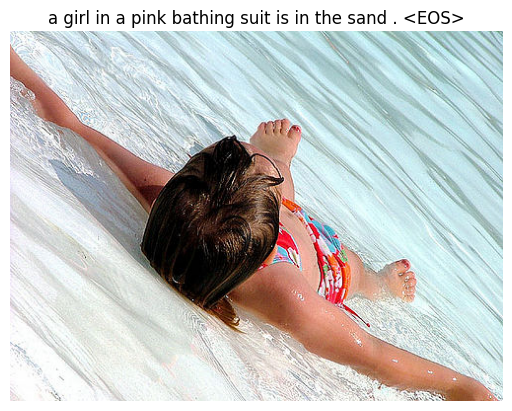

In [ ]:
with torch.no_grad():
    idx = random.randint(0, len(images))
    image_path = images[idx]
    image = cv2.imread("dataset/Images/667626_18933d713e.jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_input = transform(image).unsqueeze(0).to(device)
    caption = model.generate_caption(image_input, beam_k=5)

    plot_result(image, caption)